In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### OpenCV

In [2]:
!wget https://learnopencv.com/wp-content/uploads/2019/03/line-detection.jpg -O image.jpg

--2022-10-12 17:07:19--  https://learnopencv.com/wp-content/uploads/2019/03/line-detection.jpg
Resolving learnopencv.com (learnopencv.com)... 2606:4700:3108::ac42:2ad7, 2606:4700:3108::ac42:2929, 172.66.42.215, ...
Connecting to learnopencv.com (learnopencv.com)|2606:4700:3108::ac42:2ad7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99168 (97K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  96.84K  --.-KB/s    in 0.02s   

2022-10-12 17:07:19 (4.63 MB/s) - ‘image.jpg’ saved [99168/99168]



/var/folders/zq/4ztf70_s7qldh659t9zjz6th0000gn/T/ipykernel_66539/390397841.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


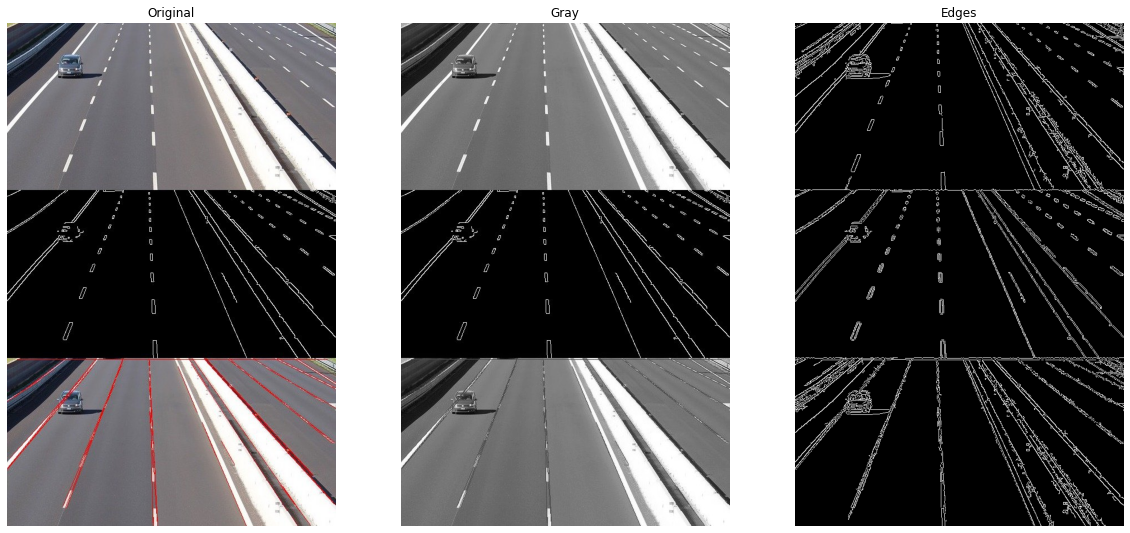

In [3]:
# Read image
src = cv2.imread("image.jpg", cv2.IMREAD_COLOR)

# Convert to grayscale image
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# Use Canny to find edges
edges = cv2.Canny(gray, 50, 200, None, 3)

f, axarr = plt.subplots(1,3,figsize=(20, 20))
[axi.set_axis_off() for axi in axarr.ravel()]
axarr[0].imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
axarr[0].set_title("Original")
axarr[1].imshow(gray, cmap=plt.get_cmap('gray'))
axarr[1].set_title("Gray")
axarr[2].imshow(edges, cmap=plt.get_cmap('gray'))
axarr[2].set_title("Edges")
f.show()

/var/folders/zq/4ztf70_s7qldh659t9zjz6th0000gn/T/ipykernel_66539/3464657511.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


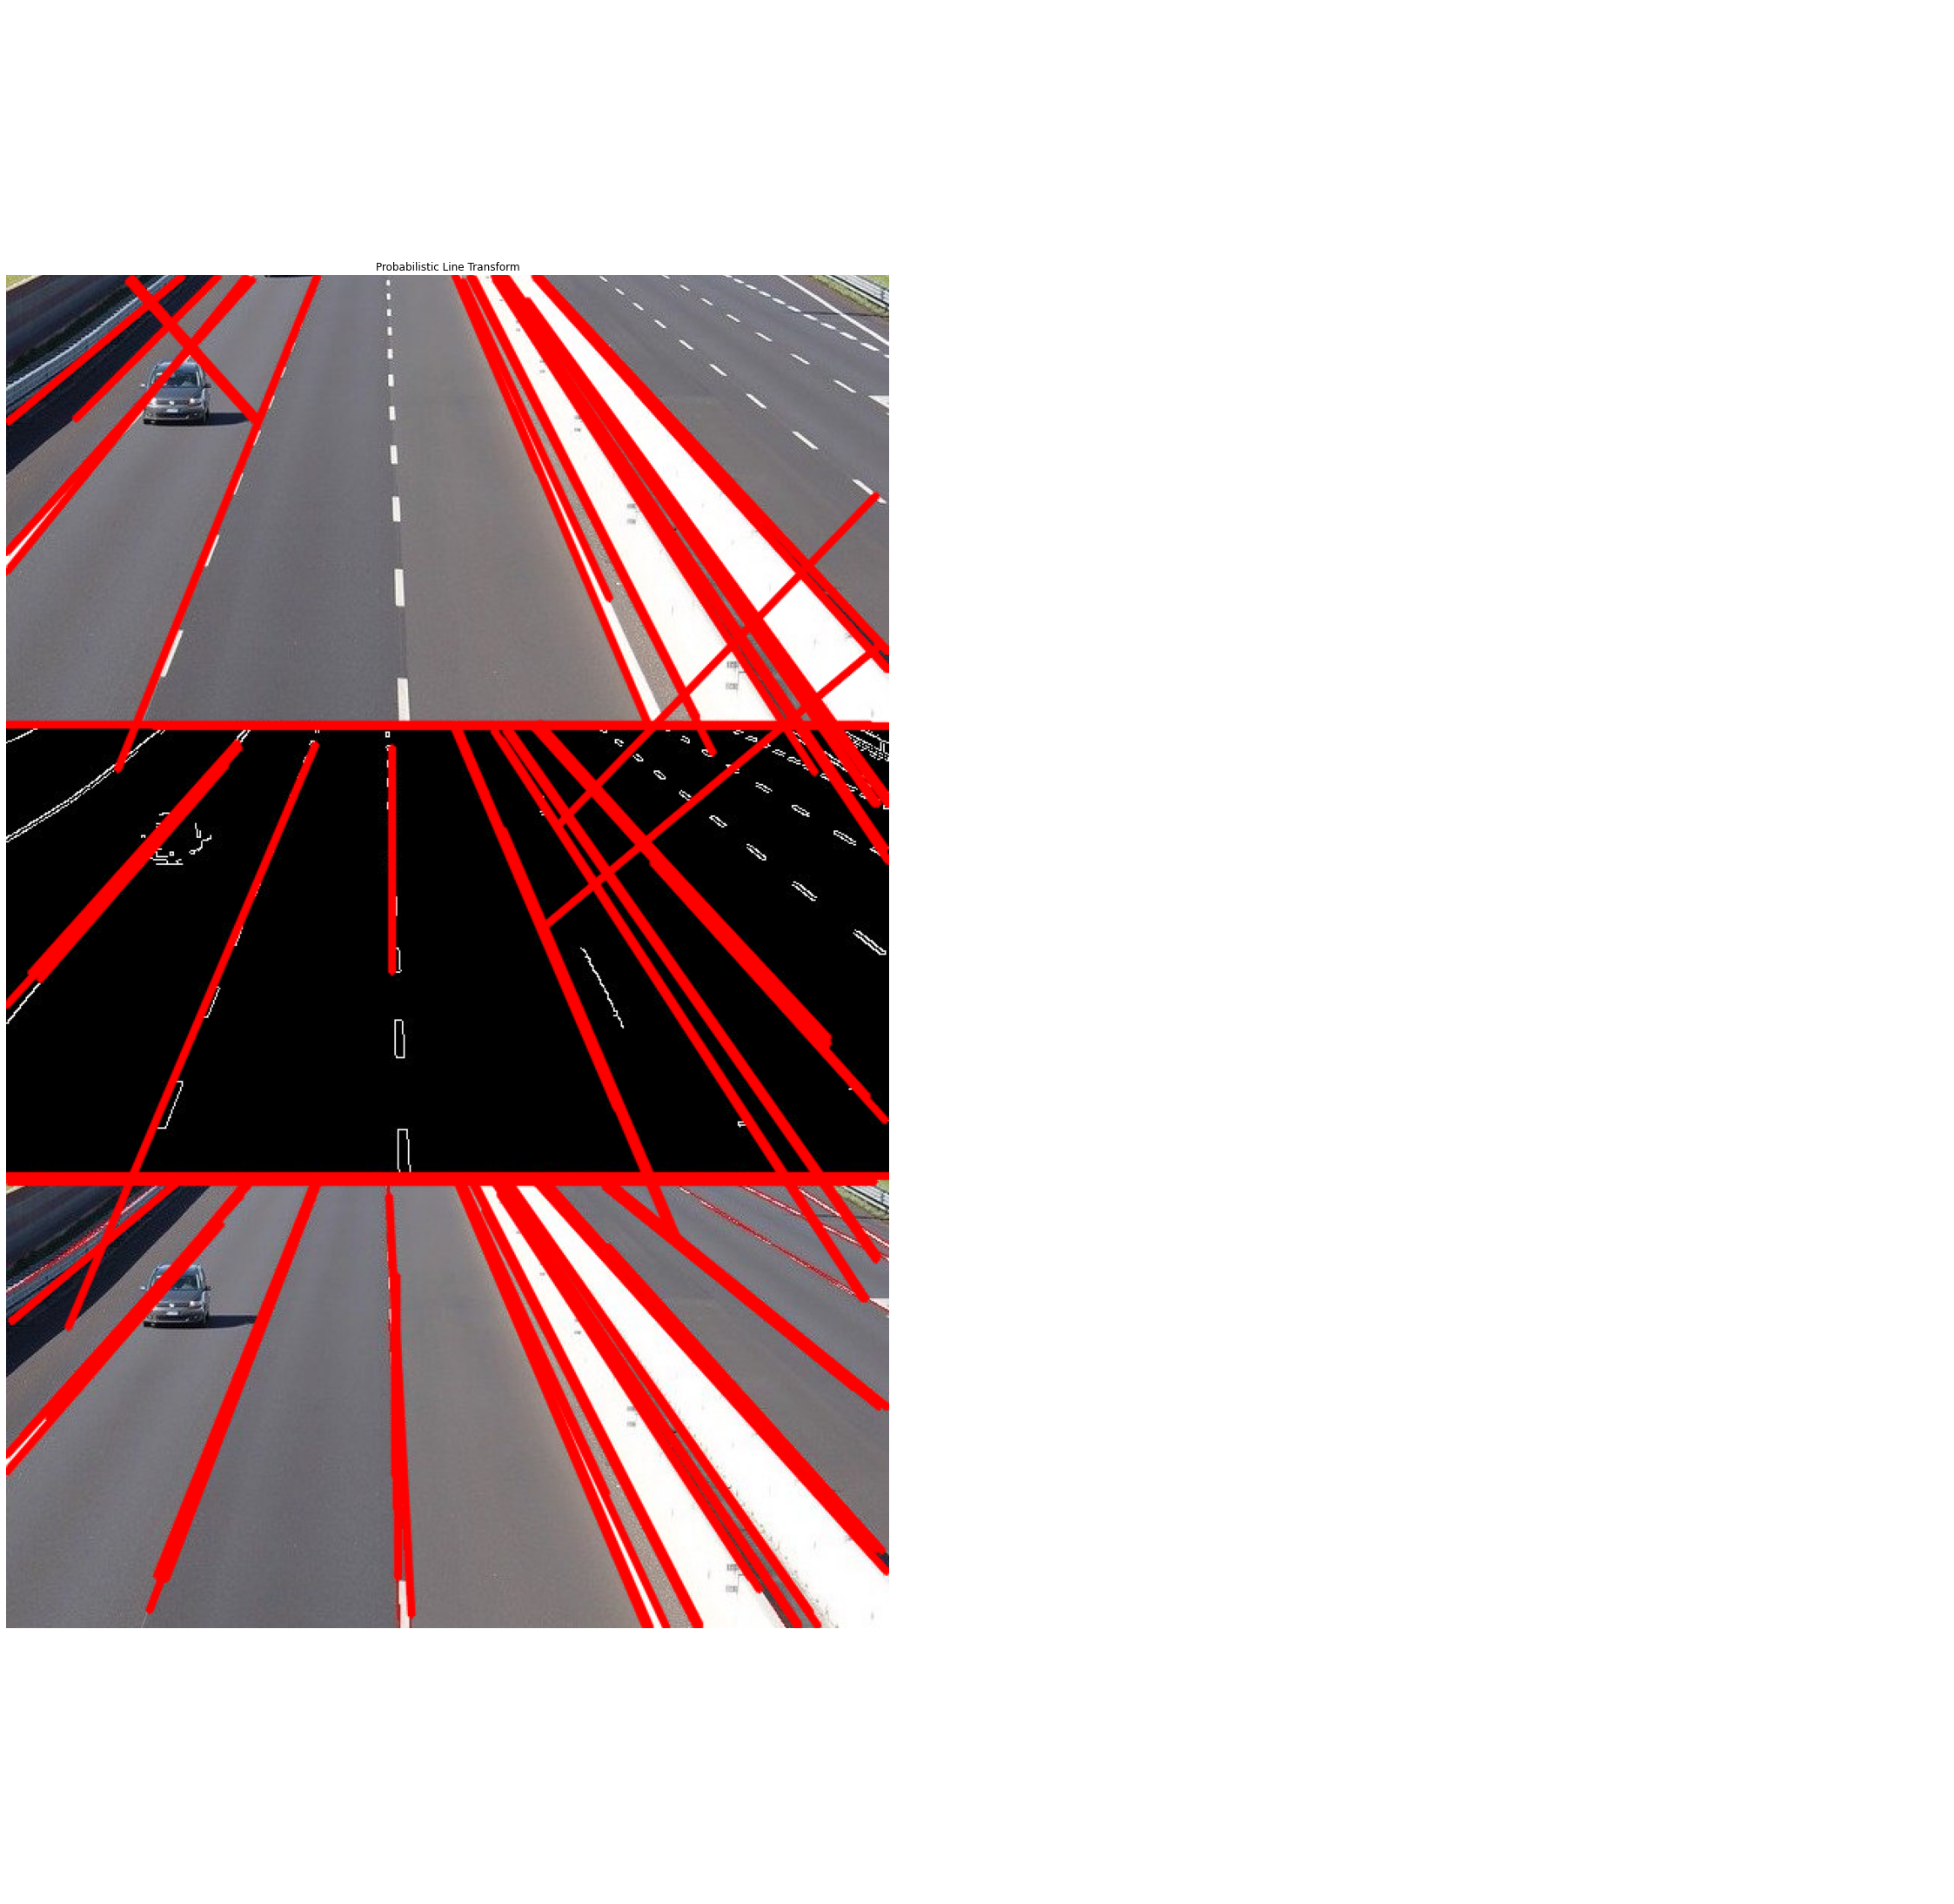

In [4]:
cdst = src.copy()
cdstP = src.copy()

lines = cv2.HoughLines(edges, 1, np.pi / 180, 150, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)


linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, None, 90, 60)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

f, axarr = plt.subplots(1,2,figsize=(40, 40))
[axi.set_axis_off() for axi in axarr.ravel()]
axarr[0].imshow(cv2.cvtColor(cdstP, cv2.COLOR_BGR2RGB))
axarr[0].set_title("Probabilistic Line Transform")
f.show()

### Hough Transform Voting

In [5]:
%cd ..
from trackers import utils
from dataset import VOT14Reader

/Users/santapo/Works/AIVN/AIVN-materials/object_tracking


In [13]:
dataset = VOT14Reader(dataset_path="./vot14")
sample = dataset[23]
x, y, w, h = sample[1][0]
frame = sample[0][0]
roi = frame[y: y + h, x: x + w]

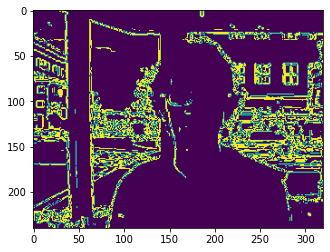

In [14]:
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
grey_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

RT = utils.build_r_table(grey_roi)
mask = cv2.inRange(hsv_roi, np.array((0.,30.,20.)), np.array((180.,255.,235.)))

roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

dst = cv2.calcBackProject([hsv],[0], roi_hist,[0,180],1)

m_dst = utils.f_dst_weights(frame, y, x, h, w)
tmp = dst*m_dst
tmp = tmp.astype('uint8')

# grey scale
frame_g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gradient_magnitude = utils.get_gradient_magnitude(frame_g)
_ , filtered = cv2.threshold(gradient_magnitude, 100, 255, cv2.THRESH_BINARY)
plt.imshow(filtered)

vote = utils.transform_hough(frame_g, RT)

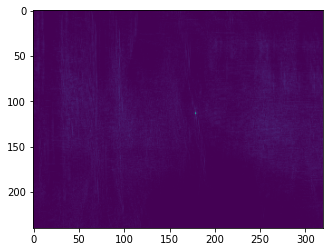

In [15]:
plt.imshow(vote)